In [1]:
# This notebook implements the examples from Lagaris and NeuralPDE 
# ["Lux", "NeuralPDE", "Zygote", "ModelingToolkit", "OrdinaryDiffEq", "LineSearches", "ProgressMeter", "Gnuplot", "Optimization", "OptimizationOptimJL", "OptimizationOptimisers"]
using Lux, NeuralPDE, Zygote
using ModelingToolkit
using ModelingToolkit: Interval
using OrdinaryDiffEq
using LineSearches
using ProgressMeter
using Gnuplot
#gpexec("load '~/gpconfig.cfg'")
import Base.show # this is needed otherwise the next line just defines a new function in a new module
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 400,250")
Gnuplot.options.verbose = false;
dump(Gnuplot.options) # print out the options

# https://julialang.slack.com/archives/C690QRAA3/p1711534935292689
# What is the relationship between Optimization.jl and Optimisers.jl?
# Optimization.jl is an interface over a whole set of optimization packages. It's the level of DifferentialEquations.jl, NonlinearSolve.jl, LinearSolve.jl, interfacing to tons (>10?) optimization packages.
# Optimisers.jl is a specific library of optimizers. Optimisers.jl is a specific library of optimizers.
# Optimization.jl has a wrapper for using Optimisers.jl methods (OptimizationOptimisers.jl), and that's the most common way things are trained with SciML applications like Neural ODEs.
# Optim.jl (OptimizationOptimJL.jl) is another Julia package implementing various algorithms to perform univariate and multivariate optimization
using Optimization, OptimizationOptimJL, OptimizationOptimisers
using Random, Statistics

Gnuplot.Options
  dry: Bool false
  cmd: String "gnuplot"
  default: Symbol default
  term: String ""
  gpviewer: Bool false
  init: Array{String}((0,))
  verbose: Bool false
  preferred_format: Symbol auto


Problem 1: A first order ODE 
$$
\frac{d} {d x} \Psi+( x+\frac{1+3 x^{2}} {1+x+x^{3}} ) \Psi=x^{3}+2 x+x^{2} \frac{1+3 x^{2}} {1+x+x^{3}} 
$$
with initial conditions $\Psi(0) = 1$, dependent variable $x$ with domain $x \in [0, 1]$.


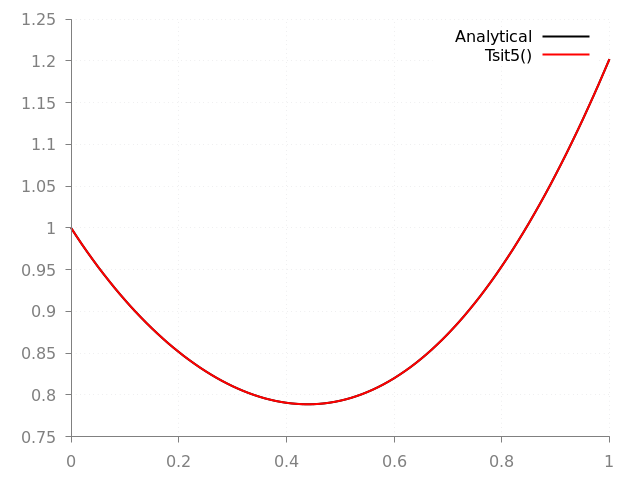

In [2]:
# Let's solve the following simple, linear ODE to get a sense of how to use the package 
linear(u, p, t) = -(t + (1 + 3*t^2)/(1 + t + t^3))*u + t^3 + 2*t + t^2*((1 + 3*t^2)/(1 + t + t^3)) # define ODE
analytical(t) = exp((-t^2)/(2))/(1 + t + t^3) + t^2 # the analytical solution

tspan = (0.0, 1.0)
u0 = 1
prob = ODEProblem(linear, u0, tspan) # we can of course solve this with traditional diffeq solvers
sol = solve(prob, Tsit5(), saveat = 0.01) # RK4 method with a newer tableau (Ch. Tsitouras, 2011)
ground_truth = analytical.(sol.t)

@gp "reset" 
@gp :- "load '~/gpconfig.cfg'"
@gp :- sol.t ground_truth "with lines title 'Analytical' lc 'black' lw 2"
@gp :- sol.t sol.u "with lines title 'Tsit5()' lc 'red' lw 2"
display(@gp)

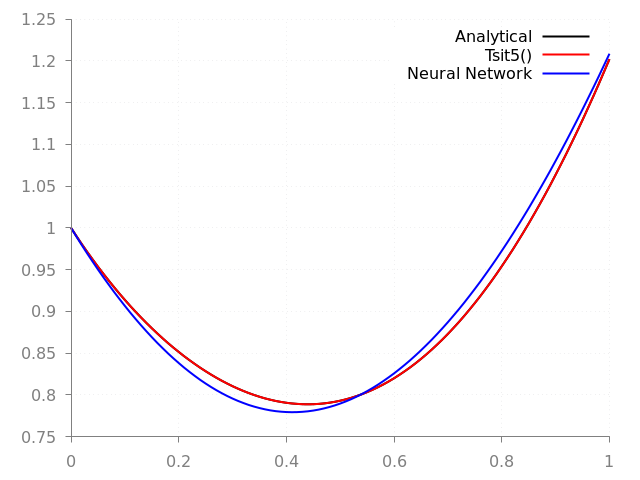

save (generic function with 2 methods)

In [3]:
# Let's the NNODE API to also solve this -- Could we use the PINNs interface to solve this also?
rng = Random.default_rng()
Random.seed!(rng, 0)
chain = Chain(Dense(1, 6, σ), Dense(6, 1)) # create a 2 layer, 6 neuron NN
ps, st = Lux.setup(rng, chain) |> Lux.f64 
opt = OptimizationOptimisers.Adam(0.1) # set up the optimiser 
alg = NNODE(chain, opt, init_params = ps, strategy=GridTraining(0.1))
nn = solve(prob, alg, verbose = false, maxiters = 100, saveat = 0.01)

@gp "reset" 
@gp :- "load '~/gpconfig.cfg'"
@gp :- sol.t ground_truth "with lines title 'Analytical' lc 'black' lw 2"
@gp :- sol.t sol.u "with lines title 'Tsit5()' lc 'red' lw 2"
@gp :- nn.t nn.u "with lines title 'Neural Network' lc 'blue' lw 2"
display(@gp)
Gnuplot.save

---- 
# Lotka Volterra Model 

Consider the Lotka Volterra model:
$$
\begin{aligned}
    \frac{dx}{dt} &= \alpha x - \beta x y \\
    \frac{dy}{dt} &= \delta x y - \gamma y
\end{aligned}
$$

2×1001 Matrix{Float64}:
 5.0  4.82567  4.65308  4.48283  4.31543  …  6.86126  6.93324   7.00477
 5.0  5.09656  5.18597  5.26791  5.34212     0.44581  0.463584  0.482377

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.

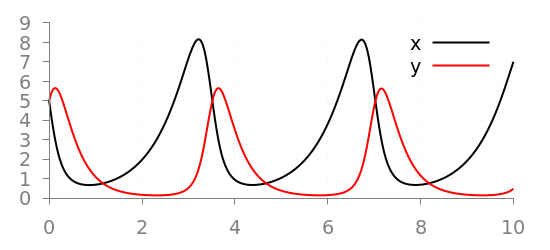

"lotka_rkmethod.png"

In [5]:
# Solve the ODE using numerical method as well as PINN method 
function lv(u, p, t)
    u₁, u₂ = u
    α, β, γ, δ = p
    du₁ = α * u₁ - β * u₁ * u₂
    du₂ = δ * u₁ * u₂ - γ * u₂
    [du₁, du₂]
end

function create_ode_prob(params) 
    tspan = (0.0, 10.0)
    u0 = [5.0, 5.0]
    prob = ODEProblem(lv, u0, tspan, params)
    return prob
end
# solve using traditional method
true_p = [1.5, 1.0, 3.0, 1.0] # true parameter values 
prob_data = create_ode_prob(true_p)
sol_data = solve(prob_data, Tsit5(), saveat = 0.01)
t_ = sol_data.t
u_ = reduce(hcat, sol_data.u)

println(t_)
display(u_)
@gp "reset" 
@gp :- "load '~/gpconfig.cfg'" 
@gp :- t_ u_[1, :] "with lines title 'x' lc 'black' lw 2" 
@gp :- t_ u_[2, :] "with lines title 'y' lc 'red' lw 2"
display(@gp)
Gnuplot.save("lotka_rkmethod.png", term="pngcairo size 550,250 fontscale 1.2")

In [6]:
# Let's set up a PINN using the ODE NNODE Interface from NeuralPDE

# Structure of the NN
# Use a function to return a newly initialized neural network
function create_nn() 
    rng = Random.default_rng()
    Random.seed!(rng, 0)
    n = 15
    # in the NNODE API - we need a single chain (1 input, 2 outputs for x, y)
    chain = Lux.Chain(
        Lux.Dense(1, n, Lux.σ),
        Lux.Dense(n, n, Lux.σ),
        Lux.Dense(n, n, Lux.σ),
        Lux.Dense(n, 2)
    )
    ps, st = Lux.setup(rng, chain) |> Lux.f64
    return chain, ps, st    
end
chain, ps, st = create_nn() #
display(chain)

# display(keys(ps))
# display(ps.layer_2.weight) # example printout of the weights

# It's easy to evaluate the Lux chain -- remember input is a vector
y, st = chain([1], ps, st) # evaluate with input 1 (a vector with one element)
display(y)

# Check by doing it manually!
a1 = Lux.σ(ps.layer_1.weight*[1] + ps.layer_1.bias)
a2 = Lux.σ(ps.layer_2.weight*a1 + ps.layer_2.bias)
a3 = Lux.σ(ps.layer_3.weight*a2 + ps.layer_3.bias)
a4 = ps.layer_4.weight*a3 + ps.layer_4.bias

Chain(
    layer_1 = Dense(1 => 15, sigmoid_fast),  # 30 parameters
    layer_2 = Dense(15 => 15, sigmoid_fast),  # 240 parameters
    layer_3 = Dense(15 => 15, sigmoid_fast),  # 240 parameters
    layer_4 = Dense(15 => 2),           # 32 parameters
)         # Total: 542 parameters,
          #        plus 0 states.

2-element Vector{Float64}:
 -0.32533660462829145
 -0.7347590994832373

2×1 Matrix{Float64}:
 -0.32533660462829134
 -0.7347590994832371

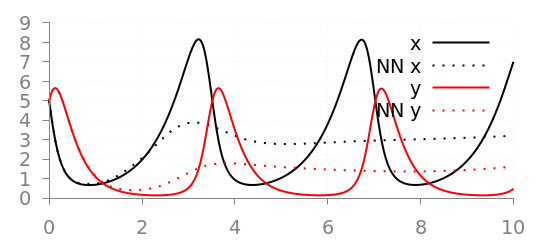

"lotka5k.png"

In [7]:
# First lets do forward simulation -- 

# How does NNODE work? 
# The loss function defined internally is the loss on collocation points 
# which are determined using the strategy -- GridStrategy being the simplest which divides the domain up into a grid
# The NNODE solution is in a form (see Lagaris) such that the initial conditions are satisified 
# so whereas in a abstract PINN, the IC/BC would be "observed" data passed in explicitly, we don't need to do that for the NNODE 

# if param_estim = false, the values of the parameters are already defined in `prob` which the ODE system
# can we still provide NNODE with default values? this doesnt really make sense -- unless also param_estim = true 
prob = create_ode_prob([1.5, 1.0, 3.0, 1.0]) # create the ODE problem with true parameters -- can the NN replicate the system?
chain, ps, st = create_nn() 
opt = LBFGS(linesearch = BackTracking()) #OptimizationOptimisers.Adam(0.01),  Descent(0.01)
alg = NNODE(chain, opt, ps; strategy = WeightedIntervalTraining([0.7, 0.2, 0.1], 500), param_estim = false) #, additional_loss = additional_loss)
sol_pinn = solve(prob, alg, verbose = false, abstol = 1e-8, maxiters = 5000, saveat = t_) 

up_ = reduce(hcat, sol_pinn.u)
@gp "reset" 
@gp :- "load '~/gpconfig.cfg'" 

@gp :- t_ u_[1, :] "with lines title 'x' lc 'black' lw 2 " 
@gp :- t_ up_[1, :] "with lines title 'NN x' lc 'black' lw 2 dt 8 " 
@gp :- t_ u_[2, :] "with lines title 'y' lc 'red' lw 2"
@gp :- t_ up_[2, :] "with lines title 'NN y' lc 'red' lw 2 dt 8"
display(@gp)
Gnuplot.save("lotka5k.png", term="pngcairo size 550,250 fontscale 1.2")

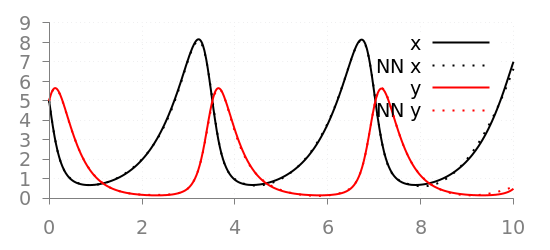

"lotka5k_withloss.png"

In [8]:
# next can we add "data" in this case the 'data' is actually just the solution to the ODE 
# still we are not estimating the parameters -- we are now giving the 'data' 

# Need to define the additional loss function 
# BUG? The NNODE API only uses a two argument additional_loss function -- why is that?
# -- it's because the parameter vector is appended to the theta itself 
# -- if param_estim = false then \theta does not include the p appended 
function additional_loss(phi, θ)
    sum(abs2, phi(t_, θ) .- u_) / size(u_, 2) # divide by the number of collocation points
end

prob = create_ode_prob([1.5, 1.0, 3.0, 1.0]) # create the ODE problem with true parameters -- can the NN replicate the system?
chain, ps, st = create_nn() 
opt = LBFGS(linesearch = BackTracking())
alg = NNODE(chain, opt, ps; strategy = WeightedIntervalTraining([0.7, 0.2, 0.1], 500), additional_loss = additional_loss)
sol_pinn = solve(prob, alg, verbose = false, abstol = 1e-8, maxiters = 5000, saveat = t_) 

up_ = reduce(hcat, sol_pinn.u)
@gp "reset" 
@gp :- "load '~/gpconfig.cfg'" 

@gp :- t_ u_[1, :] "with lines title 'x' lc 'black' lw 2 " 
@gp :- t_ up_[1, :] "with lines title 'NN x' lc 'black' lw 2 dt 8 " 
@gp :- t_ u_[2, :] "with lines title 'y' lc 'red' lw 2"
@gp :- t_ up_[2, :] "with lines title 'NN y' lc 'red' lw 2 dt 8"
display(@gp)
Gnuplot.save("lotka5k_withloss.png", term="pngcairo size 550,250 fontscale 1.2")


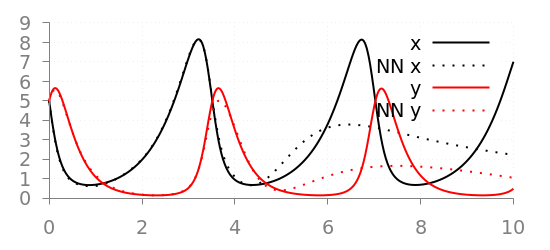

estimated parameters: [1.5057283312107748, 1.0520391360668768, 2.747859689812857, 0.9146187951634163]
true parameters: [1.5, 1.0, 3.0, 1.0]


In [14]:
# Lets turn param estimation on 
# we'll train w.r.t to data and loss 
# and again the data will just be the solution to the ODE

# create the ODE problem with false parameters
prob = create_ode_prob([1.0, 1.0, 1.0, 1.0]) 
chain, ps, st = create_nn() 
opt = LBFGS(linesearch = BackTracking())
alg = NNODE(chain, opt, ps; strategy = WeightedIntervalTraining([0.7, 0.2, 0.1], 500), 
        additional_loss = additional_loss, param_estim = true)
sol_pinn = solve(prob, alg, verbose = false, abstol = 1e-8, maxiters = 8000, saveat = t_) 
up_ = reduce(hcat, sol_pinn.u)
@gp "reset" 
@gp :- "load '~/gpconfig.cfg'" 

@gp :- t_ u_[1, :] "with lines title 'x' lc 'black' lw 2 " 
@gp :- t_ up_[1, :] "with lines title 'NN x' lc 'black' lw 2 dt 8 " 
@gp :- t_ u_[2, :] "with lines title 'y' lc 'red' lw 2"
@gp :- t_ up_[2, :] "with lines title 'NN y' lc 'red' lw 2 dt 8"
display(@gp)
Gnuplot.save("lotka5k_paramestim.png", term="pngcairo size 550,250 fontscale 1.2")

println("estimated parameters: $(sol_pinn.k.u.p)")
println("true parameters: [1.5, 1.0, 3.0, 1.0]")